### Exploration of Pyro Probabilistic Programming.
by Mark Conrad

**Credit to Uber's AI team, I pulled content from their tutorial found at http://pyro.ai/examples/intro_part_i.html**

In [2]:
import torch


In [3]:
from torch.autograd import Variable

In [4]:
import pyro
import pyro.distributions as dist

The basic unit of Pyro programs is the stochastic function. This is an arbitrary Python callable that combines two ingredients: deterministic code and primitive stochastic functions.
A stochastic function can be any Python object with __call__() method (e.g. functions, a method or PyTorch nn.Module).


Stochastic primitive functions are distributions, where we can compute the probability of the outputs given the input.
Pyro includes a standalone library, pyro.distributions, of GPU-accelerated multivariate probability distributions built on PyTorch. 

We can draw a sample x from the unit normal distribution N(0,1)

In [8]:
mu = Variable(torch.zeros(10000000)) # mean = 0
sigma = Variable(torch.ones(10000000)) # unit variance.
x = dist.normal(mu, sigma).cuda() # x is a sample from N(0,1), we can offload computation to GPUs
x

Variable containing:
-1.8223e+00
 1.6114e-01
 3.4833e-01
     ⋮     
 7.2025e-01
 7.2063e-01
 3.3839e-01
[torch.cuda.FloatTensor of size 10000000 (GPU 0)]

It is important to note that dist.normal is a function that takes parameters and dist.normal(...) returns a sample. Parameters are PyTorch Variables. Variables in PyTorch make use of PyTorch's fast tensor math and autograd capabilities (backprop). Now to score the sample x, computing its log probability according to the distribution N(0,1) we do the following. 

In [14]:
log_p = dist.normal.log_pdf(x, mu, sigma)
np.exp(log_p)

array([[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[Variable containing:
 0.3957
[torch.FloatTensor of size 1]
]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]], dtype=object)

One core language primitive in Pyro is the pyro.sample statement. Using pyro.sample is as simple as calling a primitive stochastic function with one important difference. 


In [15]:
x = pyro.sample("sample", dist.normal, mu, sigma)
x

Variable containing:
 1.0886
[torch.FloatTensor of size 1]

Just like a direct call to dist.normal, this returns a sample from the unit normal distribution. The crucial difference is that this sample is named. Pyro uses these names to uniquely identify sample statements and change their behavior at runtime depending on how the enclosing stochastic function is being used. 


In [23]:
def weather():
    """ We have data on daily mean temperatures and cloud cover and want to reason about how temperature interacts with whether
        it was sunny or cloudy. """
    
    # here we define a binary random variable cloudy which is given by a draw from the bernoulli distribution 
    # with a parameters of 0.3. 

    cloudy = pyro.sample('cloudy', dist.bernoulli, Variable(torch.Tensor([0.3])) )
    # Since this distribution returns a 0 or a 1
    # We convert the value cloud to a string so the values of weather are easier to parse through.
    cloudy = 'cloudy' if cloudy.data[0] == 1.0 else 'sunny'
    # now we define the parameters we are going to use to sample. 
    # Here the average temperatures for cloudy are 55 and 75 for sunny. 
    mean_temp = {'cloudy': [55.0], 'sunny': [75.0]}[cloudy]
    sigma_temp = {'cloudy':[10.0], 'sunny':[15.0]}[cloudy]
    temp = pyro.sample('temp', dist.normal, Variable(torch.Tensor(mean_temp)),
                      Variable(torch.Tensor(sigma_temp)))
    return cloudy, temp.data[0]
for _ in range(3):
    print(weather())

('sunny', 63.63655471801758)
('sunny', 83.60599517822266)
('cloudy', 54.24677658081055)


weather() is a non-deterministic (same input does not guarantee the same output) Python callable that returns two random samples. 
The randomness is invoked witht the pyro.sample. 
Moreover, the weather() specifies a joint probability distribution over two named random variables: cloudy and temp. 
With this, it defines a probabilistic model that we can reason about using the techniques of probability theory. 
For instance, if I observe a temperature of 70 degrees, how likely is it to be cloudy? 
We will continue to explore this in the next example.



In [31]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = [200] if cloudy == 'sunny' and temp > 80.0 else [50]
    ice_cream = pyro.sample('ice_cream',dist.normal, Variable(torch.Tensor(expected_sales)),
                           Variable(torch.Tensor([10.0])))
    return ice_cream

Uber states that Pyro is embedded into Python, stochastic functions can contain arbitrarily complex determinestic Python and randomness can freely affect control flow. We can construc t recursive functions that terminate their recursion nondeterministically, provided we take care to pass pyro.sample unique sample names whenever it's called. 

In [34]:

def geometric(p, t = None):
    """Output produced is generated dynamically and different executions can have different numbers of named random variables."""
    if t is None:
        t = 0
    x = pyro.sample("x+{}".format(t), dist.bernoulli, p)
    if torch.equal(x.data, torch.zeros(1)):
        return x
    else:
        return x + geometric(p, t+1)
print(geometric(Variable(torch.Tensor([0.5]))))

Variable containing:
 0
[torch.FloatTensor of size 1]



We can also define stochastic functions that accept as input or produce as output other stochastic functions:


In [40]:
def normal_product(mu, sigma):
    z1 = pyro.sample("z1", dist.normal, mu, sigma)
    z2 = pyro.sample("z2", dist.normal, mu, sigma)
    y = z1 * z2
    return y

# here we are defining a stochastic function
def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", dist.normal, Variable(torch.zeros(1)), Variable(torch.ones(1)))
    fn = lambda sigma: normal_product(mu_latent, sigma)
    return fn
make_normal_normal()(Variable(torch.ones(1)))

Variable containing:
-0.2674
[torch.FloatTensor of size 1]

The fact that Pyro supports arbitrary Python code like this -iteration, recursion, higher-order functions, etc - in conjunction with random control flows means that Pyro stochastic functions are universal, i.e. they can be used to represent any computable probability distribution. 

Pyro is built on top of PyTorch to take advantage of dynamic computational graphs which are an important ingredient in allowing for unviersal models that can benefit from GPU-accelerated tensor math. 


In [41]:
%matplotlib inline
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except ImportError:
    pass

import torch
from torch.autograd import Variable

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101)

## Inference in Pyro: From Stochastic Functions to Marginal Distributions

Stochastic functions induce a joint probability distribution p(y,z | x) over their latent variables z and return values y, and this joint distribution induces a marginal distribution over return values of the function. However, for non-primitive stochastic functions, we can no longer explicitly compute the marginal probability of an output p(y|x) or draw samples from the marginal distribution over return values y ~ p(y|x) 


In the most generalizeable construct, we can view inference in a universal probabilistic programming language like Pyro to be a problem of constructing this marginal distribution given an arbitrary boolean constraint so that we can perform these computations. The constrain can be deterministic, and hinge on the return value, the internal randomness, or both. 
Bayesian inference or posterior inference is an important special case of this more general formulation that admits tractable approximiations. In Bayesian inference, the return value is always the values of some subset internal sample statements, and the constraint is an equality constraint on the other internal sample statements. According to the documentation much of modern machine learning can be cast as approximate Bayesian inference and expressed succintly in a language like Pyro.
Next we will make a generative model.

#### Representing marginal distributions
Suppose we are trying to figure out how much something weights, but the scale is unreliable, we can try to compensate for this by integrating the noisy measurement info with a guess based on prior knowledge about the object, like its density or material properties. 

In [47]:
def scale(guess):
    # the prior over weight encodes our uncertainty about our guess.
    weight = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # this encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight.
    return pyro.sample('measurement', dist.normal, weight, Variable(torch.Tensor([.75])))

Let's analyze the models behavior, in particular, we can use importance sampling to simulate the marginal distribution of measurement values we'd expect to see a priori for a given guess.
Marginalization in Pyro is split between two steps, first we collect a number of weighted execution traces of the model, then we can collpase those traces into a histogram over possible return values given a particular set of arguments.
We use pyro.infer.Marginal
Sampling can be done either through sampling, or, for models with only discrete latent variables, exact enumeration. to create a basic importance sampler over execution traces (using the prior as a proposal distribution), we can write:


In [49]:
posterior = pyro.infer.Importance(scale, num_samples=1000)

By itself the posterior is not very useful, though advanced users can call it with arguments for scale to sample a raw execution trace.
Instead, the posterior is meant to be consumed by pyro.infer.Marginal, which creates a primitive stochastic function with the same input and output types as scale.


In [50]:
guess = Variable(torch.Tensor([8.5]))
marginal = pyro.infer.Marginal(posterior)
marginal(guess)

Variable containing:
 7.4698
[torch.FloatTensor of size 1]

When called with an input guess, marginal first uses posterior to generate a seuqnece of weighted execution traces given guess, then builds a histogram over return values from the traces, and finally returns a sample drawn from the histogram. Calling marginal with the same arguments more than once will sample from the same histogram. 


Text(0,0.5,'#')

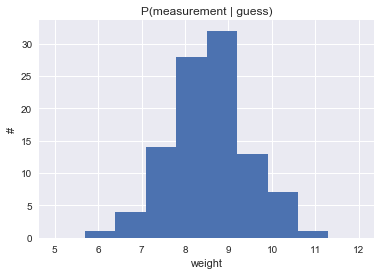

In [51]:

plt.hist([marginal(guess).data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")



pyro.infer.Marginal also accepts the optional keyword argument sites = [name1, name2, ...] that provides a list of names of latent variables. When sites is specified, marginal will return a dictionary where the keys are the names in sites and the values are values at those sites from a single execution trace. 
This is useful because we may wish to compute many different marginals from the same posterior object.




The real utility of probabilistic programming is in the ability to condition generative models on observed data and infer the latent factors that might have produced that data. In Pyro, we separate the expression of conditioning from its evaluation via inference, making it possible to write a model once and condition it on many different observations. We can constrain a models internal sample statement to be equal to a given set of observations.


We will consider scale once more, suppose we want to sample from the marginal distribution of weight give ninput guess== 0.5
but now we have observed that measurement ==0.1. Pyro provides the function pyro.condition to allow us to constrain the values of sample statements. pyro.condition is a higher-order function that takes a model and a dictionary of data and returns a new model that has the same input and output signatures but always uses the given values at observed sample statements. 

In [52]:
conditioned_scale = pyro.condition(scale, data= {"measurement": Variable(torch.Tensor([8.5]))})

This is just like a Python function, conditioning can be deferred to or parametrized with lambda or def.


In [53]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data= {'measurement': measurement})(*args, **kwargs)